## Introduction

The previous notebook (00_an_introduction_to_wmts_in_python) focused on introducing WMTS and how to use freely available services to obtain imagery. The Vexcel Data Program is a premium source of data and we manage access using token based authentication (explained further down).

The objective of this notebook is to demonstrate how to:
- perform basic API queries agains the Vexcel Data Program API using the Authentication and Tile Service API endpoints
- use functions to convert from a lat/lon pair to tile coordinates
- work with some Python plotting and image libraries to view image data returned in the API response

All of Vexcels imagery library (about 20 petabytes worth of data) can be obtained via our API - https://api.vexcelgroup.com.
There are five categories of endpoints:

- Tile services
- Authentication services
- Discrete image services
- Metadata services
- Coverage services

These categories and the API details can be found in our [API documentation](https://vexcel.atlassian.net/wiki/spaces/APIDOCS/overview?homepageId=2122350731). The purpose of this article is to give an introduction to the usage of the Tile and Authentication services as well as concepts that will allow you to use all of the other services in the other notebooks.

## Authentication and authorization

Before accessing our imagery, you need to obtain an access token. 

To get an access token, you make an API request and securely provide it your username and password. If the username and password match credentials in the system, you'll receive a token in the API response. Depending on your subsciption, the access token with authorize you access to obtain imagery from the API (by region, imagery type or resolution). Whenever you make requests to the VDP API for imagery, you must provide the token in the request to get a successful response.

All access tokens last for 12 hours, and there is no limit on how frequently you can obtain them.

In the cell below, we log in using the API credentials created when you sign up using the Viewer application https://app.vexcelgroup.com/. In subsequent notebooks, this function can be imported from the vdp_python_tools module included in this repository (`from vdp_python_tools.authentication import login`).

An important step before running this cell is to create and save a plain text file called "credentials.json" and place it in the same folder as this notebook. The JSON should just contain the following text:
`{'password': 'hopefullyabetterpasswordthanthis', 'username': 'email@address.com'}`. Just swap in your own username and password. In general, this isn't the most secure way to handle usernames and passwords - but that's getting outside the scope of this notebook. See this [article](https://dev.to/biplov/handling-passwords-and-secret-keys-using-environment-variables-2ei0#:~:text=To%20save%20passwords%20and%20secret,Setting%20click%20on%20Environment%20Variables%20.) for more.

In [1]:
import requests
import json
import os

def login(credentials=None, vdp_password_var="VDP_PASSWORD", vdp_username_var="VDP_USERNAME"):
    if credentials is None:
        password = os.environ.get(vdp_password_var)
        username = os.environ.get(vdp_username_var)
        if password is None:
            raise ValueError(f"No password found for environment variable {vdp_password_var}. Make sure to set it before calling this function")
        if username is None:
            raise ValueError(f"No username found for environment variable {vdp_username_var}. Make sure to set it before calling this function")
        credentials = {'password': password, 'username': username}
    
    r = requests.post("https://api.gic.org/auth/Login/", data=credentials)
    token = r.json()['token']
    return token

# If you want to see what the request looks like when you authenticate, you the alternative command which prints
# the request URL. Don't do it if you don't want to flash your password.

token = login()

## Tile services

The rest of this notebook gives examples on how to use that token to obtain raster tiles and view them in the notebook. There are 3 Tile API endpoints available:
- GetDSMTile
- GetDTMTile
- GetOrthoImageTile

There are subtle differences in the way these APIs are called, but the structure of the inputs and outputs from these APIs are similar enough that they can all be called from a single function. Because the responses vary in their data type and there are more parameters that can go into a request URL than the APIs used in the introductory notebook, these requests may seem more complicated but they retain that essential structure of the WMTS: `{zoom}/{x}/{y}`.

*This function can be imported from the vdp_python_tools module included in this repository (`from vdp_python_tools.get_images import get_tile`)*

In [3]:
from PIL import Image
import io

def get_tile(x, y, zoom, api, token, layer="bluesky-ultra", **kwargs):
    """
    For background on how tiles are named according to x, y and zoom, see 
    https://wiki.openstreetmap.org/wiki/Slippy_map_tilenames
    
    For more detail on each of the parameters below, see our documenation 
    https://vexcel.atlassian.net/wiki/spaces/APIDOCS/pages/2131887188/GetOrthoImageTile+Service+-+v1.4#Parameters
    
    :param x: The x coordinate of the tile. (Datum: WGS84)
    :param y: The y coordinate of the tile. (Datum: WGS84)
    :param zoom: The zoom level of the tile. 
    :param api: the API endpoint
    :param layer: the name of the layer
    :param kwargs: optional keyword arguments to be passed directly into the API call
    :returns: this is a description of what is returned
    """

    if api == "GetDSMTile" or api == "GetDTMTile": 
        url = f"https://api.vexcelgroup.com/images/{api}/{zoom}/{x}/{y}?token={token}"
        url += f"&layer={layer}"
        response = requests.get(url, params=kwargs)
        image = Image.open(io.BytesIO(response.content))
    else:
        url = f"https://api.vexcelgroup.com/images/{api}/{layer}/{zoom}/{x}/{y}?token={token}"
        response = requests.get(url, params=kwargs, stream = True)
        image = Image.open(response.raw)
    return image
        


As you can see, we're not obtaining tiles using their latitude and longitude, but rather an x and y pair with zoom level. The function below can be used to obtain a tile coordinate corresponding to a lat, lon pair and zoom level.

This function can be imported from the vdp_python_tools module included in this repository (`from vdp_python_tools.tile_math import deg2num`)

In [4]:
import math

def deg2num(lon_deg, lat_deg, zoom):
    """
    This function takes a lat, lon pair and zoom level and returns the x, y pair corresponding to those coordinates
    at that zoom level. See https://wiki.openstreetmap.org/wiki/Slippy_map_tilenames for more background.
    """
    lat_rad = math.radians(lat_deg)
    n = 2.0 ** zoom
    xtile = int((lon_deg + 180.0) / 360.0 * n)
    ytile = int((1.0 - math.asinh(math.tan(lat_rad)) / math.pi) / 2.0 * n)
    return (xtile, ytile)


In [5]:
deg2num(-122, 37, 21)

(337874, 816274)

## Putting it all together 



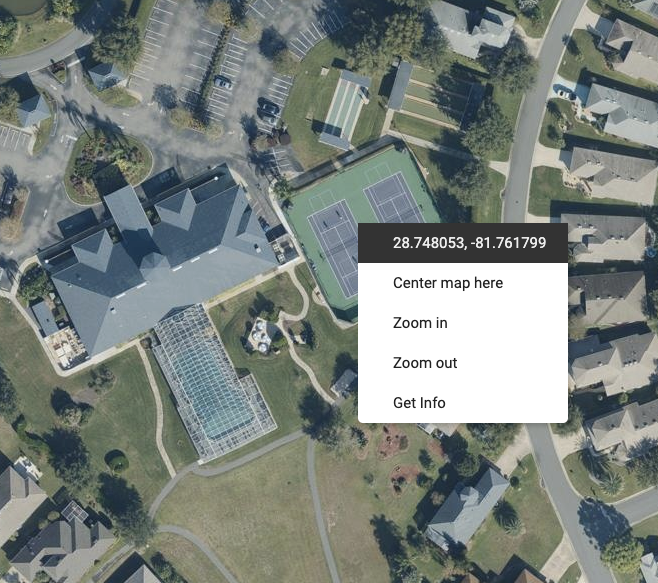

The image above is a screenshot from the Vexcel Viewer at zoom level 19. Below, we take those coordinates and use the `deg2num` functon to obtain the tile coordinates, and then use the `get_tile` function to obtain the tile as an image. You can replicate the above by going to https://app.vexcelgroup.com/#/app/home?latitude=28.74805299999997&longitude=-81.761799&zoom=19. 

143069 218400


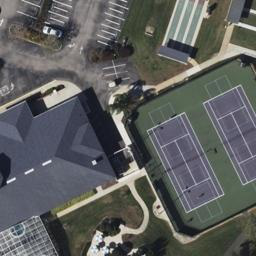

In [6]:
lat, lon = 28.748053, -81.761799
zoom = 19

x, y = deg2num(lon, lat, zoom)
print(x, y)
ortho_tile = get_tile(x, y, zoom, "GetOrthoImageTile", token)
ortho_tile

In this notebook, we use the GetOrthoImageTile and Login API endpoints to obtain a single Ortho Image tile. In subsequent notebooks, we'll go through some ways of using these calls along with other endpoints. 

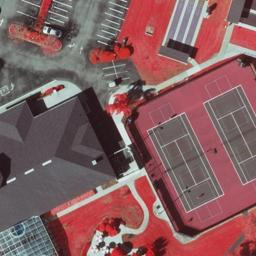

In [7]:
ortho_tile_cir = get_tile(x, y, zoom, "GetOrthoImageTile", token, renderingRule="nir")
ortho_tile_cir

As mentioned above, the responses for the DSM and DTM tiles are different to the RGB and CIR images. The RGB/CIR images have 4 channels: R, G, B and transparency or IR, R, G, and transparency. Looking at the data that underpins the image. We can look at the data in the first pixel by converting the image to an array with Numpy.

In [8]:
import numpy as np


np.array(ortho_tile_cir)[0,0]

array([125, 142, 134], dtype=uint8)

Now if we pull a DSM tile, we'll see a different format.

In [9]:
dsm_tile = get_tile(x, y, zoom, "GetDSMTile", token)
np.array(dsm_tile)[0,0]

33.440548

The first pixel of the DSM is just the height of that pixel in meters. We can then view the elevation by using a colormap. Matplotlib applies a default colorscale by creating a colormap from the minimum and maximum pixel values.

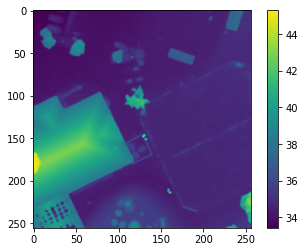

In [10]:
import matplotlib.pyplot as plt

array_dsm_tile = np.array(dsm_tile)

plt.imshow(array_dsm_tile)
cbar = plt.colorbar()

This notebook showed how to perform basic queries and visualisations of imagery from the Vexcel Data Program. Notebooks in the rest of this series perform more complex queries, processing and visualisation of the imagery, but all build on the concepts above.